# 使用G@C回收設施的原因的demographics，比如：選擇[爲獲取積分獎勵]的受訪者的[年齡層]分佈

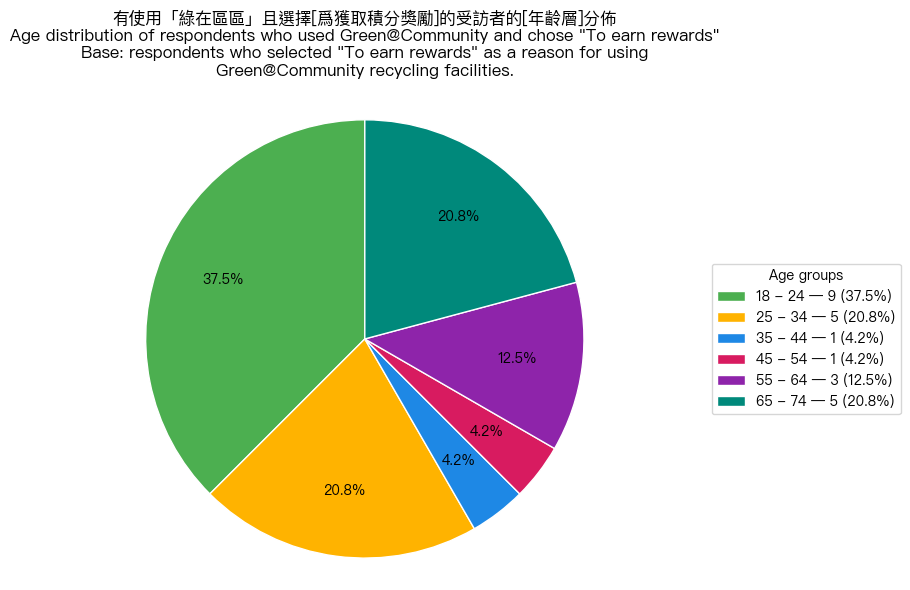

In [4]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")
_ensure("numpy")

# ---------- imports ----------
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from textwrap import wrap

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helpers to find columns ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    # explicit patterns
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

# column: reasons for using G@C
reasons_patterns = [
    r"why\s+do\s+you\s+choose\s+to\s+use\s+green@community\s+recycling\s+facilities",
    r"為甚麼你會選擇使用.*綠在區區.*回收設施",
]
reasons_col = find_col(df.columns, reasons_patterns)
if reasons_col is None:
    raise RuntimeError("Could not find the column for 'Why do you choose to use Green@Community recycling facilities?'")

# column: Age
age_patterns = [
    r"\bage\b",
    r"年齡",
]
age_col = find_col(df.columns, age_patterns)
if age_col is None:
    raise RuntimeError("Could not find the Age column.")

reasons_series = df[reasons_col].fillna("").astype(str)
age_series = df[age_col].astype(str)

# ---------- filter: respondents who selected "To earn rewards" ----------
mask_earn = reasons_series.str.contains(r"\bTo earn rewards\b", case=False, regex=True)
ages_earn = age_series[mask_earn].dropna().str.strip()

# ---------- count age groups ----------
# Preferred age order from the questionnaire
age_order_pref = [
    "17 or below",
    "18 - 24",
    "25 - 34",
    "35 - 44",
    "45 - 54",
    "55 - 64",
    "65 - 74",
    "75 - 84",
    "85 or above",
]

counts_raw = ages_earn.value_counts()
# keep preferred order, then any remaining unexpected labels
ordered_labels = [a for a in age_order_pref if a in counts_raw.index] + \
                 [a for a in counts_raw.index if a not in age_order_pref]

counts = [int(counts_raw.get(a, 0)) for a in ordered_labels]
total = sum(counts)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- legend labels ----------
pct = [(c / total * 100) if total > 0 else 0.0 for c in counts]
legend_labels = [
    f"{ordered_labels[i]} — {counts[i]} ({pct[i]:.1f}%)"
    for i in range(len(ordered_labels))
]

# ---------- plot pie chart (white background, legend on right) ----------
fig, ax = plt.subplots(figsize=(9, 6), facecolor="white")
ax.set_facecolor("white")

# high-contrast colour palette
base_colors = [
    "#4CAF50",  # green
    "#FFB300",  # amber/gold
    "#1E88E5",  # blue
    "#D81B60",  # magenta
    "#8E24AA",  # purple
    "#00897B",  # teal
    "#F4511E",  # orange-red
    "#6D4C41",  # brown
]
colors = base_colors[:len(counts)]

wedges, text_labels, autotexts = ax.pie(
    counts,
    labels=None,  # we use legend instead
    colors=colors,
    startangle=90,
    autopct=(lambda p: f"{p:.1f}%") if total > 0 else None,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor="white"),
)

ax.legend(
    wedges,
    legend_labels,
    title="Age groups",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
)

# ---------- updated title ----------
title_main = (
    "有使用「綠在區區」且選擇[爲獲取積分獎勵]的受訪者的[年齡層]分佈\n"
    "Age distribution of respondents who used Green@Community and chose \"To earn rewards\""
)
title_sub  = (
    "Base: respondents who selected \"To earn rewards\" as a reason for using "
    "Green@Community recycling facilities."
)
wrapped_sub = "\n".join(wrap(title_sub, 80))

ax.set_title(title_main + "\n" + wrapped_sub, pad=16)

ax.axis("equal")  # keep pie circular
plt.tight_layout()
plt.show()
